In [151]:
#导入相关包
import numpy as np
import torch as t
import random
import matplotlib.pyplot as plt
#import netCDF4
import datetime
import torch
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.autograd as autograd
import torch.nn.functional as F
from einops import rearrange, repeat
import os
#from config import args
#import seaborn as sns
#from global_land_mask import globe
#from scipy import interpolate
#plt.rcParams['font.sans-serif'] = ['SimHei'] #中文支持
%matplotlib inline

In [152]:
# 固定随机种子
SEED = 22

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(SEED)

In [153]:
path = '/WdHeDisk/users/zhangnong/MJO/2023_0423_Test_DataSets/Test_Datasets/'
wei = '_for7_7_35_sample.npy'

In [154]:
#只用测试
X_test = np.load(path+'X_test'+wei)
Y_test = np.load(path+'Y_test'+wei)

In [155]:
#X_test = X_test[:1840, :, :, :, :]
#Y_test = Y_test[:1840, :, :]

In [156]:
# 构造数据管道
class MJODataset(Dataset):
    def __init__(self, data,label):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return self.data[idx],self.label[idx]
batch_size = 16
#刚刚 batchsize = 32 还不错15～16天，lr = 1e-3， deacy = 0.001 ，数据集是22800， 1600， 1600， 模型三层4096， 1024， 90
#无dropout

testset = MJODataset(X_test, Y_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [157]:

if torch.cuda.is_available():
    device=torch.device("cuda:0")
else :
    device=torch.device("cpu")


In [158]:
#cnn模块
# 构建CNN单元
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if (in_channels == out_channels) and (stride == 1):
            self.res = lambda x: x
        else:
            self.res = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        
    def forward(self, x):
        # 残差
        res = self.res(x)
        res = self.bn2(res)

        x = F.relu(self.bn1(x))
        x = self.conv(x)
        x = self.bn2(x)
        
        x = x + res
        
        return x

In [159]:
#编码
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 1
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)


    def forward(self, x):
        
        batch_size, T, C = x.shape
        
        h = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)

        
        #lstm训练
        output, (h, c) = self.lstm(x, (h, c))
        #output[batch_size, time_squence, hidden_size]
        #h[2, batch_size, hidden_size]

        return   h, c

In [160]:
#解码
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        #outsize = 45
        self.num_directions = 1  
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=False)
        
        self.lstm2 = nn.LSTM(self.hidden_size, 128, self.num_layers, batch_first = True)
        
        self.fc1 = nn.Linear(self.hidden_size, self.output_size)
        #self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.fc2 = nn.Linear(128, self.output_size)

    def forward(self, x, h, c):
        # x = [batchsize, input_size]
        batch_size = x.shape[0]
        x = x.view(batch_size, 1, self.input_size)
        
        output, (h, c) = self.lstm(x, (h, c))
        
        # output(batch_size, seq_len, num * hidden_size)
        rmm1 = self.fc1(output)  # pred(batch_size, 1, output_size)
        
        output, _ = self.lstm2(output)
        rmm2 = self.fc2(output)
        
        rmm1 = rmm1[:, -1, :]
        rmm2 = rmm2[:, -1, :]

        return rmm1, rmm2, h, c

In [161]:
#定义模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 1152
        self.output_size = 35
        self.hidden_size = 1024
        self.num_layers = 1
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3)
        self.conv2=CNNBlock(16, 16, 3, 1, 1)
        self.conv3=CNNBlock(16, 32, 3, 2, 1)
        self.conv4=CNNBlock(32, 32, 3, 1, 1)
        self.conv5=CNNBlock(32, 64, 3, 2, 1)
        self.conv6=CNNBlock(64, 64, 3, 1, 1)
        self.conv7=CNNBlock(64, 128, 3, 2, 1)
        self.conv8=CNNBlock(128, 128, 3, 1, 1)

        
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))#(16,4,69)
        self.flatten = nn.Flatten()
        
        self.Encoder = Encoder(self.input_size, self.hidden_size, self.num_layers)
        self.Decoder = Decoder(self.input_size, self.hidden_size, self.num_layers, self.output_size)

    def forward(self, x):
        
        x = x[:, :, :, :, 0:3]
        batch_size, seq_len, H, W, C = x.shape
        x = x.permute(0, 1, 4, 2, 3).contiguous()
        x = x.view(batch_size * seq_len, C, H, W)
        
        #cnn部分
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)

        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        _, C_new = x.shape
        
        x = x.view(batch_size, seq_len, C_new)
        
        
        
        h, c = self.Encoder(x)
        
        outputs_rmm1 = torch.zeros(batch_size, seq_len, self.output_size).to(device)
        outputs_rmm2 = torch.zeros(batch_size, seq_len, self.output_size).to(device)
        
        for t in range(seq_len):
            _input = x[:, t, :]
            
            output1, output2, h, c = self.Decoder(_input, h, c)
            
            outputs_rmm1[:, t, :] = output1
            outputs_rmm2[:, t, :] = output2
        
        rmm1 = outputs_rmm1[:, -1, :]
        rmm2 = outputs_rmm2[:, -1, :]
        
        rmm1 = rmm1.squeeze()
        rmm2 = rmm2.squeeze()
        
        rmm1 = rmm1.unsqueeze(2)
        rmm2 = rmm2.unsqueeze(2)

        RMM = torch.cat((rmm1, rmm2), dim = 2)
        
        return RMM

In [162]:
model = Model()
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv2): CNNBlock(
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): CNNBlock(
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (res): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
  )
  (conv4): CNNBlock(
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [163]:
#cor函数
def cor(Y_test,t_preds):
    #Y_test = mean_std(Y_test)
    #t_preds = mean_std(t_preds)
    cor_day = []
    a=0
    b=0
    c=0
    score_cor=0
    for i in range(0,35):
        for j in range(0,len(Y_test)):
            a+=(Y_test[j,i,:]*t_preds[j,i,:]).sum()
            b+=(Y_test[j,i]**2).sum()
            c+=(t_preds[j,i]**2).sum()
        b=np.sqrt(b)
        c=np.sqrt(c)
        cor=a/(b*c)
        cor_day.append(cor)
        a=0
        b=0
        c=0
    cor_day=np.array(cor_day)
    #print(cor_day)
    for i in range(0,len(cor_day)):
        if cor_day[i]<0.50:
            break
    score_cor=i
    return score_cor

def rmse_new(Y_valid,preds):
    #Y_valid = mean_std(Y_valid)
    #preds = mean_std(preds)
    rmse_day = []
    a=0
    score_rmse=0
    for i in range(0,35):
        for j in range(0,len(Y_valid)):
            a+=(torch.pow((Y_valid[j,i,:]-preds[j,i,:]),2)).sum()
        rmse=a/len(Y_valid)
        rmse=np.sqrt(rmse)
        rmse_day.append(rmse)
        a=0
    rmse_day=np.array(rmse_day)
    #print(rmse_day)
    for i in range(0,len(rmse_day)):
        if rmse_day[i]>1.40:
            break
    score_rmse=i
    '''
    day_cal=np.argwhere(rmse_day<1.40)
    print(day_cal)
    if len(day_cal)==0:
        score_rmse=0
    else:
        score_rmse=day_cal.max()+1
    '''
    #score_rmse=rmse_day.max()
    return score_rmse

def rmse_max(Y_valid,preds):
    #Y_valid = mean_std(Y_valid)
    #preds = mean_std(preds)
    rmse_day = []
    a=0
    score_rmse=0
    for i in range(0,35):
        for j in range(0,len(Y_valid)):
            a+=(torch.pow((Y_valid[j,i,:]-preds[j,i,:]),2)).sum()
        rmse=a/len(Y_valid)
        rmse=np.sqrt(rmse)
        rmse_day.append(rmse)
        a=0
    rmse_day=np.array(rmse_day)
    score_rmse=rmse_day.max()
    return score_rmse

In [164]:
# 加载最佳模型权重
model.to(device)
#checkpoint = torch.load('/WdHeDisk/users/zhangnong/MJO/908_test(the best)/cnn_seq2seq_s2s_data_weights.pth')
checkpoint = torch.load('/WdHeDisk/users/zhangnong/MJO/908_test(the best)/27day(cnn128).pth')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [165]:
Y_test = t.from_numpy(Y_test)

In [166]:
# 在测试集上评估模型效果
model.eval()
#model.to(device)
t_scores_rmse = []
#t_scores_cor=[]
t_s = 0
#t_ss=0
t_preds = np.zeros((len(Y_test),35,2))
for i, data in tqdm(enumerate(testloader)):
    data1, labels = data
    data1 = data1.to(device)
    labels = labels.to(device)
    t_pred = model(data1)
    #t_pred= t_pred.permute(0,2,1).contiguous()
    t_preds[i*batch_size:(i+1)*batch_size] = t_pred.detach().cpu()
t_preds = torch.as_tensor(t_preds)
#t_s=rmse(Y_test,t_preds)
t_s = rmse_new(Y_test, t_preds)
t_ss = cor(Y_test,t_preds)
t_scores_rmse.append(t_s)
#t_scores_cor.append(t_ss)
print('Score_rmse: {:.3f}'.format(t_s))
print('Score_cor: {:.3f}'.format(t_ss))

116it [00:01, 62.23it/s]


Score_rmse: 34.000
Score_cor: 24.000


In [167]:
#cor评价指标
def cor_caluate(Y_test,t_preds):
    cor_day = []
    a=0
    b=0
    c=0
    for i in range(0,35):
        for j in range(0,len(Y_test)):
            a+=(Y_test[j,i,:]*t_preds[j,i,:]).sum()
            b+=(Y_test[j,i]**2).sum()
            c+=(t_preds[j,i]**2).sum()
        b=np.sqrt(b)
        c=np.sqrt(c)
        cor=a/(b*c)
        cor_day.append(cor)
        a=0
        b=0
        c=0
    cor_day=np.array(cor_day)
    print(cor_day)
    return cor_day

In [168]:
#画cor指标
def cor_acc(cor_day):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(cor_day, label='cor_acc')
    ax1.set_xlabel('days')
    ax1.set_ylabel('cor')
    ax1.set_title('MJO Bivariate Correlation')
    ax1.legend()
    ax1.axhline(y=0.5,color='red',linewidth=0.85)
    plt.tight_layout()

In [169]:
#rmse评价指标
def rmse_caluate(Y_test,t_preds):
    rmse_day = []
    a=0
    for i in range(0,35):
        for j in range(0,len(Y_test)):
            a+=((Y_test[j,i,:]-t_preds[j,i,:])**2).sum()
        rmse=a/len(Y_test)
        rmse=np.sqrt(rmse)
        rmse_day.append(rmse)
        a=0
    rmse_day=np.array(rmse_day)
    print(rmse_day)
    return rmse_day

In [170]:
#画rmse指标
def rmse_acc(rmse_day):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(rmse_day, label='rmse_acc')
    ax1.set_xlabel('days')
    ax1.set_ylabel('rmse')
    ax1.set_title('MJO Bivariate Correlation')
    ax1.legend()
    ax1.axhline(y=1.4,color='red',linewidth=0.85)
    plt.tight_layout()

[0.87287807 0.84149885 0.80525999 0.76575253 0.72862503 0.6999357
 0.67123706 0.64825265 0.62806943 0.61182978 0.59824601 0.59037321
 0.58762293 0.58143445 0.57437855 0.56729641 0.55902677 0.55341986
 0.54804164 0.54441541 0.53694144 0.52623843 0.51309641 0.50111833
 0.48733674 0.47290057 0.46319002 0.44875203 0.43474627 0.42026607
 0.40855214 0.39862679 0.38388731 0.36993836 0.35777187]


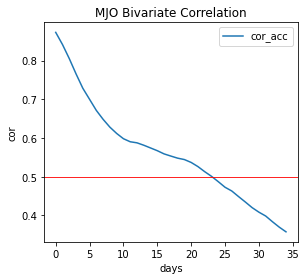

In [171]:
cor_day = cor_caluate(Y_test, t_preds)
cor_acc(cor_day)

[0.63355724 0.67850826 0.7220448  0.76135774 0.79211245 0.81082053
 0.82865796 0.84269331 0.85425256 0.86210995 0.86822793 0.86874628
 0.86550065 0.86381645 0.86531664 0.86369636 0.86233805 0.8622125
 0.85849549 0.85323664 0.85199491 0.85819867 0.86334328 0.8676806
 0.87528775 0.87974811 0.87831105 0.87776804 0.88134006 0.88423163
 0.88725188 0.89112327 0.89460741 0.8929869  0.89130197]


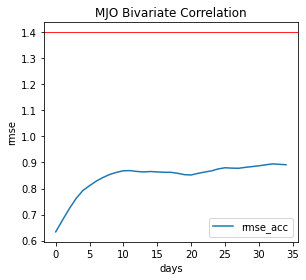

: 

In [172]:
re_rmse_day = rmse_caluate(Y_test, t_preds)
rmse_acc(re_rmse_day)